# ASSIGNMENT ON MODEL SELECTION

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

 ### Read the dataset to python environment

In [2]:
titanic=pd.read_csv(r"C:\Users\aksmk\OneDrive\Desktop\DSA\Assignments\6\titanic_dataset .csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## PRE - PROCESSING

### Check basic information about the dataset

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Columns 'Age', 'Cabin' and 'Embarked' have null values.

In [4]:
titanic['PassengerId'].nunique()

891

Since column 'PassengerId' contains full of unique values, drop it or make it as index column.

In [5]:
titanic.set_index('PassengerId',inplace=True)

Since the columns 'Name' and 'Ticket' does not contribute to predict our target variable 'Survived', drop them.

In [6]:
titanic.drop(['Name','Ticket'],axis=1,inplace=True)

'SibSp' and 'Parch' would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. So combine them and drop initial ones.

In [7]:
titanic['Relatives'] = titanic['SibSp'] + titanic['Parch']
titanic.drop(['SibSp','Parch'],axis=1,inplace=True)

### Null value imputation

Since the column 'Cabin' contains 77% null values, it will be better to drop the entire column itself instead of imputation.

In [8]:
titanic.drop('Cabin',axis=1,inplace=True)

Since column 'Embarked' is a categotical data, use mode for missing value imputation.

In [9]:
titanic.Embarked=titanic.Embarked.fillna(titanic.Embarked.mode()[0])

In [10]:
titanic.Age.skew()

0.38910778230082704


Since column 'Age' is a skewed distribution, use median for imputation of missing values.

In [11]:
titanic.Age=titanic.Age.fillna(titanic.Age.median())

### Check again for null values

In [12]:
titanic.isna().sum()

Survived     0
Pclass       0
Sex          0
Age          0
Fare         0
Embarked     0
Relatives    0
dtype: int64

Now there are no null values present in the dataset. All null values are imputed properly.



### Boxplot for checking outliers

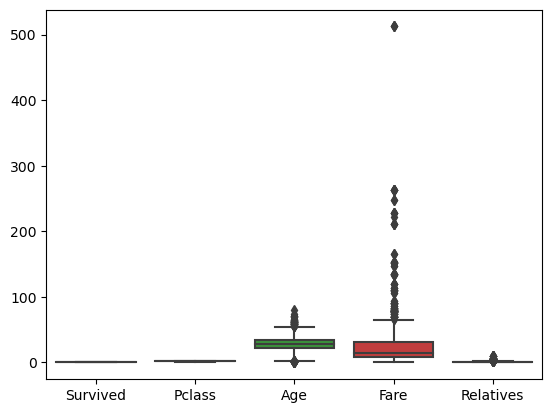

In [13]:
sns.boxplot(titanic)
plt.show()

The columns 'Age', 'Fare'  and 'Relatives' have outliers.

In [14]:
for i in ['Age','Fare','Relatives']:
    print('Skewness value of column', i, 'is', titanic[i].skew())

Skewness value of column Age is 0.5102446555756495
Skewness value of column Fare is 4.787316519674893
Skewness value of column Relatives is 2.7274414739308535


All are skewed distributions. So use IQR (Inter Quartile Range) method for outlier detection.

### IQR method for outlier detection and clip function for outlier handling

In [15]:
for i in ['Age','Fare','Relatives']:
    Q1=np.percentile(titanic[i],25,method='midpoint')
    Q3=np.percentile(titanic[i],75,method='midpoint')
    IQR=Q3-Q1
    low_lim=Q1-1.5*IQR
    up_lim=Q3+1.5*IQR
    outliers=[]
    for j in titanic[i]:
        if ((j < low_lim) | (j > up_lim)):
            outliers.append(j)    
    titanic[i]=titanic[i].clip(lower=low_lim,upper=up_lim) 

### Check again for outliers using boxplot

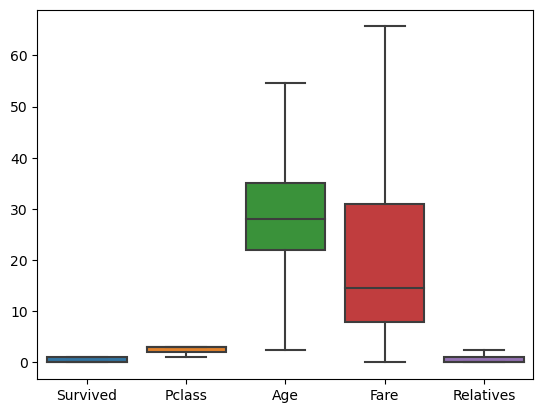

In [16]:
sns.boxplot(titanic)
plt.show()

Outliers are removed.

### One hot encoding

Encode columns 'Sex' and 'Embarked'

In [17]:
titanic=pd.get_dummies(titanic).astype(float)

### Min max scaling

In [18]:
minmax=MinMaxScaler()
titanic_mm=minmax.fit_transform(titanic)
titanic_mm=pd.DataFrame(titanic_mm,columns=titanic.columns)

### Correlation

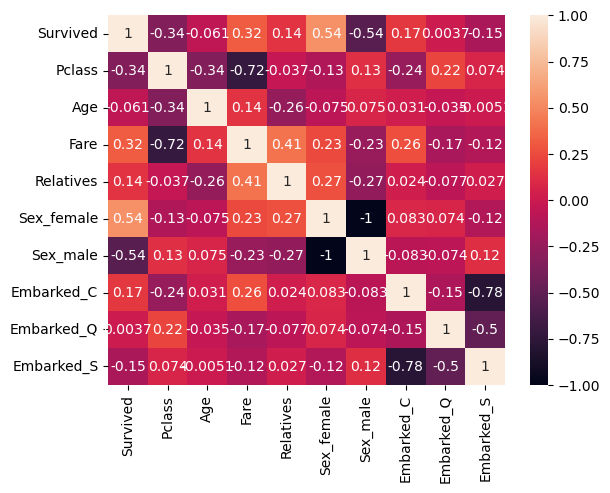

In [19]:
sns.heatmap(titanic_mm.corr(),annot=True)
plt.show()

There are no columns with high correlation.

# MODELLING

Predictors/ independent variables, x = Pclass, Age, Fare, Relatives, Sex and Embarked

Target / dependent variable, y = Survived

### Differentiate x, y and split train, test

In [20]:
x=titanic_mm.drop('Survived',axis=1)
y=titanic_mm.Survived
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)

## KNN

### To find k value

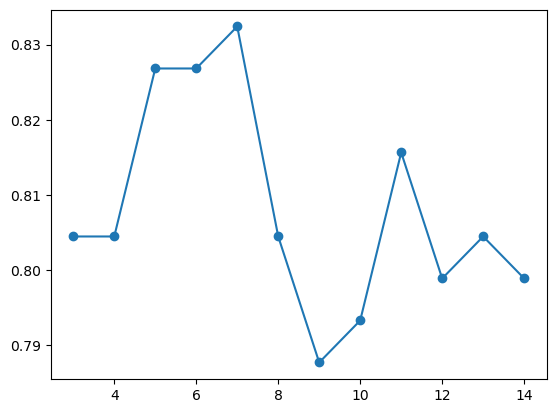

In [21]:
metric_k=[]
neighbors=np.arange(3,15)
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,metric='manhattan')
    knn.fit(x_train,y_train)
    knn_pred=knn.predict(x_test)
    metric_k.append(accuracy_score(y_test,knn_pred))
plt.plot(neighbors,metric_k,'o-')    
plt.show()

High accuracy is for k = 7. So choose it and do classification.

In [22]:
knn=KNeighborsClassifier(n_neighbors=7,metric='manhattan')
knn.fit(x_train,y_train)
knn_pred=knn.predict(x_test)
print('Accuracy of KNN Classifier is', round(accuracy_score(y_test,knn_pred)*100,2))

Accuracy of KNN Classifier is 83.24


## SVM

In [23]:
svm=SVC(class_weight='balanced')
svm.fit(x_train,y_train)
svm_pred=svm.predict(x_test)
print('Accuracy of SVM Classifier is', round(accuracy_score(y_test,svm_pred)*100,2))

Accuracy of SVM Classifier is 79.33


# CROSS VALIDATION

## K Fold

In [24]:
kfold_validator=KFold(10,shuffle=True,random_state=42)

### KNN

In [25]:
cv_result_knn=cross_val_score(knn,x,y,cv=kfold_validator)
print('Average cross validation score of KNN classifier is', cv_result_knn.mean())

Average cross validation score of KNN classifier is 0.7878277153558053


### SVM

In [26]:
cv_result_svm=cross_val_score(svm,x,y,cv=kfold_validator)
print('Average cross validation score of SVM classifier is', cv_result_svm.mean())

Average cross validation score of SVM classifier is 0.8002122347066167


## Stratified K Fold

In [27]:
strat_validator=StratifiedKFold(n_splits=10,shuffle=True,random_state=10)

### KNN

In [28]:
str_cv_result_knn=cross_val_score(knn,x,y,cv=strat_validator)
print('Average cross validation score of KNN classifier is',str_cv_result_knn.mean())

Average cross validation score of KNN classifier is 0.7956928838951309



### SVM

In [29]:
str_cv_result_svm=cross_val_score(svm,x,y,cv=strat_validator)
print('Average cross validation score of SVM classifier is', str_cv_result_svm.mean())

Average cross validation score of SVM classifier is 0.8103245942571785



# Comparison between Cross Validation Techniques

In [30]:
mux = pd.MultiIndex.from_product([['Average Cross Validation Score'],['K Fold','Stratified K Fold']])
model=['KNN','SVM']
comp_table = pd.DataFrame([[cv_result_knn.mean(),str_cv_result_knn.mean()],[cv_result_svm.mean(),str_cv_result_svm.mean()]],columns=mux)
comp_table.index=model
comp_table

Average Cross Validation Score                  
                            K Fold Stratified K Fold
KNN                       0.787828          0.795693
SVM                       0.800212          0.810325

OBSERVATIONS: 
    
1. Average cross validation scores of both KNN and SVM classifiers are slightly improved for stratified k fold technique     compared to k fold technique.

2. For both cross validation techniques, SVM classifier performs better than KNN classifier.